In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import sklearn.feature_extraction
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Neural network basics 1

An **artificial neural network** (as opposed to a biological one) is a kind of **machine learning model** that works with tensors of numbers.
It can be trained with examples of how an input tensor should be transformed into an output tensor, for example, to turn photos (a matrix of numbers) of dogs into the scalar number 1 and photos of cats into the number 0.

[It all started](https://cs.stanford.edu/people/eroberts/courses/soco/projects/neural-networks/History/history1.html) in 1943 when McCulloch and Pitts published a paper with a primitive description of how neurons (brain cells) worked.
It took until 1958 for Rosenblatt to create the **perceptron**, a computational model of a single neuron that could perform tasks such as shape recognition.
Unfortunately, there was a lot of hype on what these models could do, such as claiming that [they could recognise photos of tanks from photos of trucks](https://www.coursera.org/learn/neural-networks/lecture/pgU1w/perceptrons-the-first-generation-of-neural-networks-8-min).
Although perceptrons are too simple to actually do this correctly, it was pulled off by cheating.
It turned out that the photos of the tanks were taken in sunny weather whilst those of the trucks were taken in cloudy weather, which means that measuring the average pixel intensity was all that was needed to distinguish the two.

Let's look at how these simple models work.

## The linear model

A perceptron is a type of **linear model**, so called because it consists (mostly) of a linear equation like this:

$$y = w x + b$$

where $w$ is the gradient of the line, called the weight, $b$ is the y-intercept of the line, called the bias, $x$ is the input number, and $y$ is the output number.

Changing $w$ and $b$ will change what $y$ will be for given values of $x$.
Let's look at an example.

Let's say you want $y$ to be 0 when $x$ is 1 and $y$ to be 1 when $x$ is 0.
The previous sentence can be expressed as the following table called a **training set**:

| $x$ | $y$ |
|-----|-----|
| 0   | 1   |
| 1   | 0   |

Now we want to find which values of $w$ and $b$ will make $y = w x + b$ match the above table.
The answer is $w = -1$ and $b = 1$.
Let's see this in PyTorch:

In [2]:
class Linear(torch.nn.Module):

    def __init__(self, w, b):
        super().__init__()
        self.w = torch.nn.Parameter(torch.tensor(w, dtype=torch.float32))
        self.b = torch.nn.Parameter(torch.tensor(b, dtype=torch.float32))

    def forward(self, x):
        return self.w*x + self.b

model = Linear(-1, 1)
model.to(device)
print('x', 'y')
print(0, model(0))
print(1, model(1))

x y
0 tensor(1., grad_fn=<AddBackward0>)
1 tensor(0., grad_fn=<AddBackward0>)


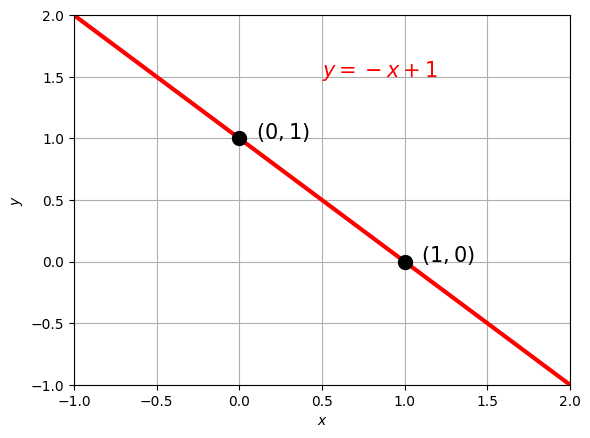

In [3]:
(fig, ax) = plt.subplots(1, 1)

xs = np.arange(-2.0, 2.1, 0.1)
ys = np.array([
    model(x).detach().cpu().tolist()
    for x in np.arange(-2.0, 2.1, 0.1)
])

ax.set_xlim(-1.0, 2.0)
ax.set_ylim(-1.0, 2.0)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.plot(xs, ys, color='red', linestyle='-', linewidth=3)
ax.plot([0], [1], linestyle='', marker='o', markersize=10, color='black')
ax.plot([1], [0], linestyle='', marker='o', markersize=10, color='black')
ax.text(0.1, 1.0, '$(0, 1)$', color='black', fontsize=15.0)
ax.text(1.1, 0.0, '$(1, 0)$', color='black', fontsize=15.0)
ax.text(0.5, 1.5, '$y = -x + 1$', color='red', fontsize=15.0)
ax.grid()

Let's called the above graph an **input-output plot** as it shows what the model is predicting the output should be for different input values.

What if we want to use two inputs instead?
In that case, we'd just give the second input its own weight and add it to the equation like this:

$$y = w_0 x_0 + w_1 x_1 + b$$

This will now give us a 3D input-output plot.
Let's say that you want to learn the following training set:

| $x_0$ | $x_1$ | $y$ |
|-------|-------|-----|
| 0     | 0     | -1  |
| 0     | 1     | 0   |
| 1     | 0     | 0   |
| 1     | 1     | 1   |

Which values of $w_0$, $w_1$, and $b$ will make $y = w_0 x_0 + w_1 x_1 + b$ match the above table?
The answer is $w_0 = 1$, $w_1 = 1$, and $b = -1$:

In [4]:
class Linear(torch.nn.Module):

    def __init__(self, w0, w1, b):
        super().__init__()
        self.w0 = torch.nn.Parameter(torch.tensor(w0, dtype=torch.float32))
        self.w1 = torch.nn.Parameter(torch.tensor(w1, dtype=torch.float32))
        self.b = torch.nn.Parameter(torch.tensor(b, dtype=torch.float32))

    def forward(self, x0, x1):
        return self.w0*x0 + self.w1*x1 + self.b

model = Linear(1, 1, -1)
model.to(device)
print('x0', 'x1', 'y')
print(0, 0, model(0, 0))
print(0, 1, model(0, 1))
print(1, 0, model(1, 0))
print(1, 1, model(1, 1))

x0 x1 y
0 0 tensor(-1., grad_fn=<AddBackward0>)
0 1 tensor(0., grad_fn=<AddBackward0>)
1 0 tensor(0., grad_fn=<AddBackward0>)
1 1 tensor(1., grad_fn=<AddBackward0>)


Text(0, 0, '$y = x_0 + x_1 - 1$')

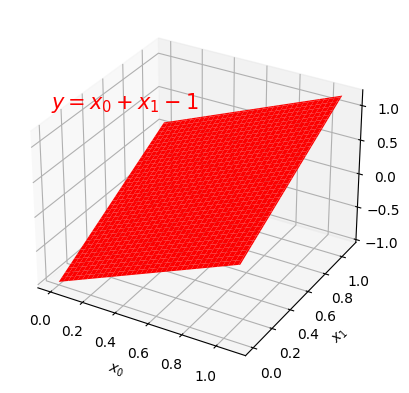

In [5]:
(fig, ax) = plt.subplots(1, 1, subplot_kw={'projection': '3d'})
ax.set_xlabel('$x_0$')
ax.set_ylabel('$x_1$')
ax.set_zlabel('$y$')

(xs1, xs0) = np.mgrid[0.0:1.1:0.01, 0.0:1.1:0.01]
ys = np.array([
    [
        model(x0, x1).detach().cpu().tolist()
        for x1 in np.arange(0.0, 1.1, 0.01)
    ]
    for x0 in np.arange(0.0, 1.1, 0.01)
])
ax.plot_surface(xs0, xs1, ys, color='red', linewidth=0, antialiased=True)
ax.text3D(0, 0, 1.5, '$y = x_0 + x_1 - 1$', color='red', fontsize=15.0)

What if we wanted an output of 1 when both inputs are 1 and an output of 0 otherwise, which is a function called the **AND gate**?

| $x_0$ | $x_1$ | $y$ |
|-------|-------|-----|
| 0     | 0     | 0   |
| 0     | 1     | 0   |
| 1     | 0     | 0   |
| 1     | 1     | 1   |

With a simple linear model, this would be impossible because a flat plane cannot pass through those four points.
We can do this by changing the model so that it won't be a flat plane anymore, that is, a **non-linear model**.

## The perceptron

The output of linear models is **unbounded** (can be as large as you want).
For many tasks, it is preferred if the output is always within some range, such as a binary output (0 or 1 only).
Perceptrons take the linear model and transform the output to be either 1 or -1, depending on whether the linear model gave a positive or a negative output.
Mathematically, this is expressed with the `sign` function:

In [6]:
print(' 12:', np.sign(12))
print('-23:', np.sign(-23))

 12: 1
-23: -1


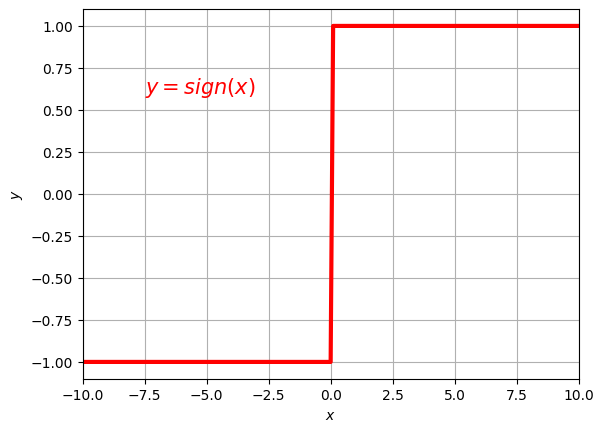

In [7]:
(fig, ax) = plt.subplots(1, 1)

xs = np.mgrid[-10:10.1:0.1]
ys = [np.sign(x) for x in np.arange(-10.0, 10.1, 0.1)]

ax.set_xlim(-10.0, 10.0)
ax.set_ylim(-1.1, 1.1)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.plot(xs, ys, color='red', linestyle='-', linewidth=3)
ax.text(-7.5, 0.6, '$y = sign(x)$', color='red', fontsize=15.0)
ax.grid()

So the perceptron is defined as $\text{sign}(w x + b)$.
If we treat the -1 output as if it was a 0, then the previous table of desired outputs can be achieved by using the perceptron $\text{sign}(x_0 + x_1 - 1.5)$:

In [8]:
class Perceptron(torch.nn.Module):

    def __init__(self, w0, w1, b):
        super().__init__()
        self.w0 = torch.nn.Parameter(torch.tensor(w0, dtype=torch.float32))
        self.w1 = torch.nn.Parameter(torch.tensor(w1, dtype=torch.float32))
        self.b = torch.nn.Parameter(torch.tensor(b, dtype=torch.float32))

    def forward(self, x0, x1):
        return torch.sign(self.w0*x0 + self.w1*x1 + self.b)

model = Perceptron(1, 1, -1.5)
model.to(device)
print('x0', 'x1', 'y')
print(0, 0, model(0, 0))
print(0, 1, model(0, 1))
print(1, 0, model(1, 0))
print(1, 1, model(1, 1))

x0 x1 y
0 0 tensor(-1., grad_fn=<SignBackward0>)
0 1 tensor(-1., grad_fn=<SignBackward0>)
1 0 tensor(-1., grad_fn=<SignBackward0>)
1 1 tensor(1., grad_fn=<SignBackward0>)


Text(0, 0, '$y = sign(1 x_0 + 1 x_1 - 1.5)$')

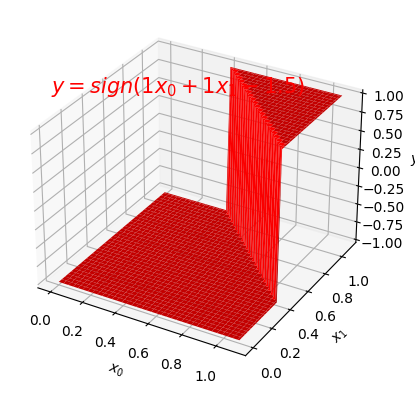

In [9]:
(fig, ax) = plt.subplots(1, 1, subplot_kw={'projection': '3d'})
ax.set_xlabel('$x_0$')
ax.set_ylabel('$x_1$')
ax.set_zlabel('$y$')

(xs1, xs0) = np.mgrid[0.0:1.1:0.01, 0.0:1.1:0.01]
ys = np.array([
    [
        model(x0, x1).detach().cpu().tolist()
        for x1 in np.arange(0.0, 1.1, 0.01)
    ]
    for x0 in np.arange(0.0, 1.1, 0.01)
])
ax.plot_surface(xs0, xs1, ys, color='red', linewidth=0, antialiased=True)
ax.text3D(0, 0, 1.5, '$y = sign(1 x_0 + 1 x_1 - 1.5)$', color='red', fontsize=15.0)

Note how the input-output plot is flat everywhere except for where it transitions from -1 to 1.

Now that we've seen how perceptrons work, we'll never talk about them again.
The perceptron is of historical interest but we're interested in another simple model that is closer to modern neural networks: the **logistic regression classifier**.

## The logistic regression classifier

### Using sigmoid

The logistic regression classifier is the simplest type of modern neural network.
Instead of passing the linear model's output through a sign function, the logistic regression classifier passes it through a **logistic function**, also known as a **sigmoid function** or $\sigma$, which is a mathematical function that turns any number into a fraction between 0 and 1.
It is defined as follows:

$$\sigma(x) = \frac{1}{1 + e^{-x}}$$

where $e$ is Euler's number which is approximately 2.718.

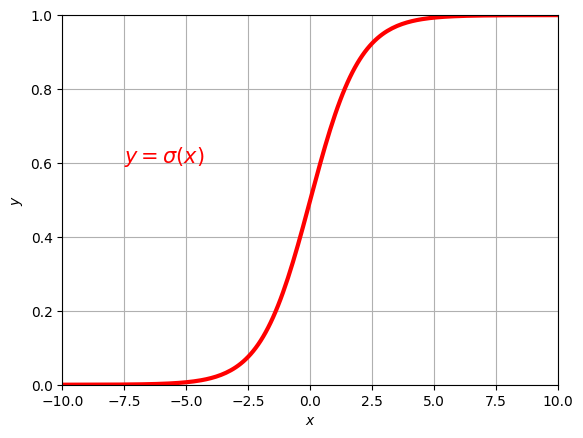

In [10]:
(fig, ax) = plt.subplots(1, 1)

xs = np.mgrid[-10.0:10.1:0.1]
ys = [1/(1 + np.exp(-x)) for x in np.arange(-10.0, 10.1, 0.1)]

ax.set_xlim(-10.0, 10.0)
ax.set_ylim(0.0, 1.0)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.plot(xs, ys, color='red', linestyle='-', linewidth=3)
ax.text(-7.5, 0.6, '$y = \sigma(x)$', color='red', fontsize=15.0)
ax.grid()

The sigmoid function is very interesting.
It is steepest at $x=0$, where $y=0.5$, and gets closer and closer to 1 or 0 the further $x$ goes in the positive or negative direction respectively.
It never equals 1 or 0, no matter how large a value of $x$ you give it, and all values of $y$ are unique, that is, all the numbers between $-\infty$ and $\infty$ are squashed into the tiny range between 0 and 1, without using a $y$ number more than once.

We can now put this function on top of the linear model, like this:

$$y = \sigma(w_0 x_0 + w_1 x_1 + b)$$

This is called a logistic regression classifier.
With this, we can make a function that approximates the AND gate described above by using $w_0 = 10$, $w_1 = 10$, and $b = -15$, like this:

In [11]:
class Logistic(torch.nn.Module):

    def __init__(self, w0, w1, b):
        super().__init__()
        self.w0 = torch.nn.Parameter(torch.tensor(w0, dtype=torch.float32))
        self.w1 = torch.nn.Parameter(torch.tensor(w1, dtype=torch.float32))
        self.b = torch.nn.Parameter(torch.tensor(b, dtype=torch.float32))

    def forward(self, x0, x1):
        return torch.sigmoid(self.w0*x0 + self.w1*x1 + self.b)

model = Logistic(10, 10, -15)
model.to(device)
print('x0', 'x1', 'y')
print(0, 0, model(0, 0))
print(0, 1, model(0, 1))
print(1, 0, model(1, 0))
print(1, 1, model(1, 1))

x0 x1 y
0 0 tensor(3.0590e-07, grad_fn=<SigmoidBackward0>)
0 1 tensor(0.0067, grad_fn=<SigmoidBackward0>)
1 0 tensor(0.0067, grad_fn=<SigmoidBackward0>)
1 1 tensor(0.9933, grad_fn=<SigmoidBackward0>)


Text(0, 0, '$y = \\sigma(10 x_0 + 10 x_1 - 15)$')

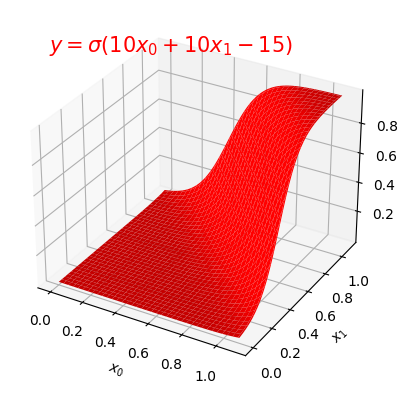

In [12]:
(fig, ax) = plt.subplots(1, 1, subplot_kw={'projection': '3d'})
ax.set_xlabel('$x_0$')
ax.set_ylabel('$x_1$')
ax.set_zlabel('$y$')

(xs1, xs0) = np.mgrid[0.0:1.1:0.01, 0:1.1:0.01]
ys = np.array([
    [
        model(x0, x1).detach().cpu().tolist()
        for x1 in np.arange(0.0, 1.1, 0.01)
    ]
    for x0 in np.arange(0.0, 1.1, 0.01)
])
ax.plot_surface(xs0, xs1, ys, color='red', linewidth=0, antialiased=True)
ax.text3D(0, 0, 1.5, '$y = \sigma(10 x_0 + 10 x_1 - 15)$', color='red', fontsize=15.0)

Note that the $y$ values are not exactly the same as those in the training set, but they are approximately equal.
This simple function can approximate quite a few things as long as the output is some kind of yes/no answer or a probability of some kind (the probability that a photo contains a dog, for example).

In general, for a given number of inputs, the logistic regression classifier is defined as follows:

$$y = \sigma\left(b + \sum_i{w_i x_i}\right)$$

If we consider the weights and inputs to be vectors, then we can rewrite the above using a dot product.

$$y = \sigma(b + w \cdot x)$$

This allows us to work with any number of inputs, but we can also have any number of outputs.
If you want to have two outputs (two yes/no answers) for the same input vector, you can either have two separate logistic regression classifiers that each return one of the outputs, or you combine them into one model by using a matrix for the weights.
Let's see an example.

$x = (\begin{matrix}100 & 200\end{matrix})$

Model A: $y = \sigma\left(1 + (\begin{matrix}10 & 20\end{matrix})\cdot(\begin{matrix}100 & 200\end{matrix})\right) = \sigma(5001) \approx 1.0$

Model B: $y = \sigma\left(2 + (\begin{matrix}30 & 40\end{matrix})\cdot(\begin{matrix}100 & 200\end{matrix})\right) = \sigma(11002) \approx 1.0$

Combined: $y = \sigma\left((\begin{matrix}1 & 2\end{matrix}) + (\begin{matrix}100 & 200\end{matrix})\left(\begin{matrix}10 & 30 \\ 20 & 40\end{matrix}\right)\right) = \sigma((\begin{matrix}5001 & 11002\end{matrix})) \approx (\begin{matrix}1.0 & 1.0\end{matrix})$

The above will give you a vector with two separate numbers.
Notice that sigmoid never equals 1 in theory, no matter how large the input is, but on a computer it rounds up to 1 when the input is large enough.
Let's see what this matrix notation looks like in PyTorch.

In [13]:
class Logistic(torch.nn.Module):

    def __init__(self, w, b):
        super().__init__()
        self.w = torch.nn.Parameter(torch.tensor(w, dtype=torch.float32))
        self.b = torch.nn.Parameter(torch.tensor(b, dtype=torch.float32))

    def forward(self, x):
        return torch.sigmoid(x@self.w + self.b)

model = Logistic(np.array([[10, 30], [20, 40]]), np.array([1, 2]))
model.to(device)
print('model((100  200)) =', model(torch.tensor([[100, 200]], dtype=torch.float32, device=device)))

model((100  200)) = tensor([[1., 1.]], grad_fn=<SigmoidBackward0>)


Remember that PyTorch does not matrix-multiply a vector to a matrix but only a matrix to a matrix.
For this reason we converted the input vector to a single row matrix (`[[100, 200]]`) and got a single row matrix as output.
Notice also that the input vector must be converted to a PyTorch tensor before it is used in a matrix multiplication.

### Using softmax

The result of the above PyTorch module was a vector (single row matrix actually) of two numbers, each of which was the result of a sigmoid function, which means that these two numbers can be interpreted as two separate probabilities.
But sometimes you don't want two independent probabilities but a **probability distribution**, that is, where all the probabilities add up to 1.
For example, when classifying if a text is written in English, German, or Russian, you'd want the three probabilities to add up to 1 because the answer has to be exactly one of them.

If you want to have a probability distribution instead of a set of independent probabilities as output, then you'll need to replace the sigmoid with a **softmax**, which is defined as follows:

$$y_i = \frac{e^{x_i}}{\sum_j e^{x_j}}$$

where $y$ is the vector of probabilities returned by the softmax function, $y_i$ is the $i$<sup>th</sup> value in vector $y$, and $x$ is the input vector.

In [14]:
softmax = lambda xs: np.exp(xs)/np.sum(np.exp(xs))
print(softmax(np.array([1, 2], np.float32)))

[0.26894143 0.73105854]


Let's define this in PyTorch:

In [15]:
class Logistic(torch.nn.Module):

    def __init__(self, w, b):
        super().__init__()
        self.w = torch.nn.Parameter(torch.tensor(w, dtype=torch.float32))
        self.b = torch.nn.Parameter(torch.tensor(b, dtype=torch.float32))

    def forward(self, x):
        return torch.softmax(x@self.w + self.b, dim=1)

model = Logistic(np.array([[10, 30], [20, 40]]), np.array([1, 2]))
model.to(device)
print('model((100  200)) =', model(torch.tensor([[100, 200]], dtype=torch.float32, device=device)))

model((100  200)) = tensor([[0., 1.]], grad_fn=<SoftmaxBackward0>)


Notice the `dim` parameter in the softmax function.
When used on a matrix, softmax can make either the rows (`dim=1`) or columns (`dim=0`) sum to one.

We have described everything with equations up to now, but these logistic regression equations are often described graphically using arrows and circles.
Below is the diagram for a three input classifier with a single input.

![](single_neuron.png)

The circle is called a **neural unit** and is what generates the output.
It has a single bias under it ($b$) and each input ($x_1$, $x_2$, and $x_3$) is connected to it via weights ($w_1$, $w_2$, $w_3$).

A multi-output classifier looks a bit more complicated:

![](multi_neuron.png)

Note how weights have the notation $w_{st}$ where $s$ is the source and $t$ is the target (so $w_{21}$ is connecting $x_2$ to $y_1$).
In order to simplify the diagram for more complex models we use block diagrams instead that hide away the clutter:

![](block_diagram.png)

## The gradient descent algorithm

Up to now we've seen how to use models whose parameters ($w$ and $b$) are given, but how do you find them if they are not?
Let's start by trying to manually set the parameters of a logistic regression classifier.
Recall that this model has two types of parameters, the weights and the biases, each of which can be any number you want.

In the website linked below, you need to manually set the weights and bias of a logistic regression classifier in order to identify faces of women from faces of men using four features: whether they have glasses, whether they have long hair, whether they have a beard, and whether they have a necklace.
You need to move the sliders on the weights and bias in order to make the faces of women in the training set have a white border (their sigmoid value is 1) and faces of men have a black border (their sigmoid value is 0).

[the website](https://mtanti.github.io/teaching/nnsim/)

To automatically find the values of the parameters, we use an algorithm called the **gradient descent algorithm**, which, unsurprisingly, works using gradients.
To understand it, we will first need to understand what an **error function** is.

### Error functions

The gradient descent algorithm works by adjusting parameters to minimise an **error**, that is, some kind of quantified distance from the current model to the perfect model.
The smaller the error, the closer the model's behaviour is to what we'd like it to do.
Let's look at three examples of two-input model outputs:

Model A:

| $x_0$ | $x_1$ | target output | actual output |
|-------|-------|---------------|---------------|
| 0     | 0     | 0             | 0.00005       |
| 0     | 1     | 0             | 0.50000       |
| 1     | 0     | 0             | 0.00005       |
| 1     | 1     | 1             | 0.50000       |

Model B:

| $x_0$ | $x_1$ | target output | actual output |
|-------|-------|---------------|---------------|
| 0     | 0     | 0             | 0.00005       |
| 0     | 1     | 0             | 0.00000       |
| 1     | 0     | 0             | 0.50000       |
| 1     | 1     | 1             | 0.00005       |

Model C:

| $x_0$ | $x_1$ | target output | actual output |
|-------|-------|---------------|---------------|
| 0     | 0     | 0             | 0.99995       |
| 0     | 1     | 0             | 1.00000       |
| 1     | 0     | 0             | 0.50000       |
| 1     | 1     | 1             | 0.99995       |

Which of these models' actual output is the closest to the target output?
An error function would turn each of these target-actual output pairs into a single number such that the closer the number is to zero, the better the model.
A common error function to use is the **mean square error** (**MSE**) which takes the differences between targets and outputs, squares the differences (this makes all the differences positive), and takes the mean of the square differences:

$$E = \frac{1}{n}\sum_i{(t_i - y_i)^2}$$

where $t$ is the list of target outputs, $y$ is the list of actual outputs, and $n$ is the number of outputs (the size of the training set).

We can measure the MSE of each model above (with respect to the training set) as follows:

Model A error: $\frac{1}{4}\left((0-0.00005)^2 + (0-0.50000)^2 + (0-0.00005)^2 + (1-0.50000)^2\right) = 0.12500$

Model B error: $\frac{1}{4}\left((0-0.00005)^2 + (0-0.00000)^2 + (0-0.50000)^2 + (1-0.00005)^2\right) = 0.06250$

Model C error: $\frac{1}{4}\left((0-0.99995)^2 + (0-1.00000)^2 + (0-0.50000)^2 + (1-0.99995)^2\right) = 0.81245$

So it seems that model B is producing the smallest error and so is the closest to the target.

What happens if we have multiple targets and outputs per row in the training set?
In that case, we would just treat each individual target-output pair as separate and take the mean of all the errors as if they were on separate rows.

This is how to use MSE in PyTorch:

In [16]:
y = torch.tensor([0.00005, 0.50000, 0.00005, 0.50000], dtype=torch.float32, device=device)
t = torch.tensor([0.0,     0.0,     0.0,     1.0], dtype=torch.float32, device=device)
error = torch.nn.functional.mse_loss(y, t)
print(error)

tensor(0.1250)


Note that error function is sometimes called other things such as **loss function**, **cost function**, and **energy function**.

Now that we understand what an error is, let's see how to use it to automatically find the parameters of a logistic regression classifier.

### Parameter optimisation

**Parameter optimisation** is the mathematical term for searching for the parameters in a model that will make the error smaller.
Let's say that we need to find the right parameters for the following model and training set:

$$y = \sigma(x w + b)$$

| $x$ | $y$ |
|-----|-----|
| 0   | 1   |
| 1   | 0   |

A good set of parameters to use are $w=-10$ and $b=5$.

In [17]:
class Logistic(torch.nn.Module):

    def __init__(self, w, b):
        super().__init__()
        self.w = torch.nn.Parameter(torch.tensor(w, dtype=torch.float32))
        self.b = torch.nn.Parameter(torch.tensor(b, dtype=torch.float32))

    def forward(self, x):
        return torch.sigmoid(x*self.w + self.b)

model = Logistic(-10, 5)
model.to(device)
print('x', 'y')
print(0, model(0))
print(1, model(1))

x y
0 tensor(0.9933, grad_fn=<SigmoidBackward0>)
1 tensor(0.0067, grad_fn=<SigmoidBackward0>)


But we want to automatically find these parameters.
For simplicity we'll assume that the weight is fixed to -10 and that we only need to automatically find the bias.

$$y = \sigma(-10 x + b)$$

The first thing we're going to do to find the $b$ that minimises the model error is measure the error of the model at different values of $b$.
If we're using MSE to measure the error, then our error at different values of $b$ is going to be measured using the following equation:

$$E = \frac{1}{n} \sum_i (y_i - \sigma(-10(x_i) + b))^2$$
$$E = \frac{1}{2} \left((1 - \sigma(-10(0) + b))^2 + (0 - \sigma(-10(1) + b))^2\right)$$

For example, first term in the equation above refers to the first row in the training set above.
It has a target of 1 and the actual output will be $\sigma(-10(0) + b)$ for a given $b$.

Let's look at a graph of how this error changes as $b$ is varied.

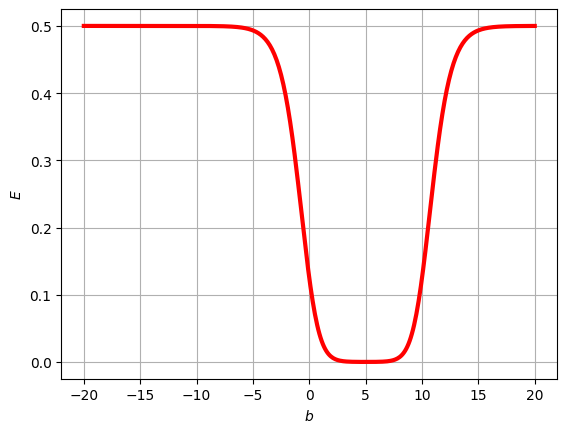

In [18]:
(fig, ax) = plt.subplots(1, 1)

sig = lambda x:1/(1 + np.exp(-x))
xs = np.mgrid[-20:20.1:0.1]
ys = 0.5*((1 - sig(-10*0 + xs))**2 + (0 - sig(-10*1 + xs))**2)

ax.set_xlabel('$b$')
ax.set_ylabel('$E$')
ax.plot(xs, ys, color='red', linestyle='-', linewidth=3)
ax.grid()

We're in luck!
There is a very clear value of $b$ that will make $E=0$.
The above graph is called an **error surface** or **parameter-error plot**, and when the shape of the error surface has a single valley like the one above, we call it **convex**.
Convex error surfaces are great because they are very easy to optimise.
Had this been a **non-convex** surface then there could have been many vallies at different levels of depth and finding the deepest one (the one that gives the smallest error) is very difficult in general.

To find the minimum point in this graph, or, rather, somewhere close to it, we can use the gradient descent algorithm which works as follows:

1. Start from a randomly chosen point on the graph.
1. Find the gradient of the graph at that point.
1. The gradient will tell you in which direction the graph is sloping downwards (towards larger or smaller values of $b$), so move in that direction for a small step.
1. Repeat points 2 and 3 for a given number of steps.

Let's follow these points.
We start from a random point on the graph, such as at $b=-4.14$.

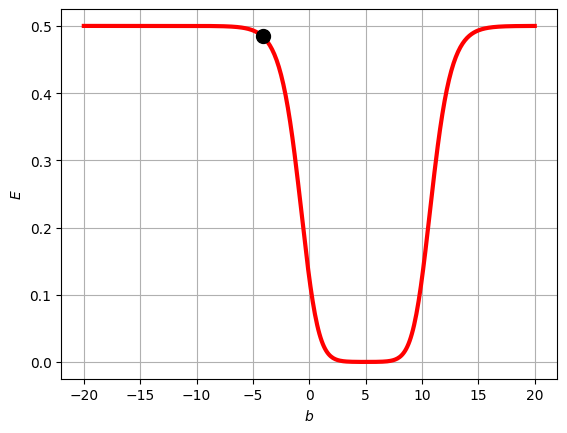

In [19]:
(fig, ax) = plt.subplots(1, 1)

sig = lambda x:1/(1 + np.exp(-x))
f = lambda x:0.5*((1 - sig(-10*0 + x))**2 + (0 - sig(-10*1 + x))**2)
xs = np.mgrid[-20:20.1:0.1]
ys = f(xs)

b = -4.14

ax.set_xlabel('$b$')
ax.set_ylabel('$E$')
ax.plot(xs, ys, color='red', linestyle='-', linewidth=3)
ax.plot([b], [f(b)], color='black', linestyle='', marker='o', markersize=10)
ax.grid()

Next we need to determine whether we need to increase or decrease $b$ in order to make the error smaller.
To do this, we take the gradient of the error function at the given point.
Remember that all module attributes marked as parameters are gradient enabled by default.

In [20]:
class Logistic(torch.nn.Module):

    def __init__(self, b):
        super().__init__()
        self.w = torch.nn.Parameter(torch.tensor(-10.0, dtype=torch.float32))
        self.b = torch.nn.Parameter(torch.tensor(b, dtype=torch.float32))

    def forward(self, x):
        return torch.sigmoid(x*self.w + self.b)

model = Logistic(-4.14)
model.to(device)
output = model(torch.tensor([0.0, 1.0], dtype=torch.float32, device=device))
target = torch.tensor([1.0, 0.0], dtype=torch.float32, device=device)
error = torch.nn.functional.mse_loss(output, target)
error.backward()
print(model.b.grad)

tensor(-0.0152)


According to PyTorch, the gradient at that point is -0.0152.
A negative gradient means that the curve is sloping downwards (from left to right) so we need to increase $b$ in order to get a smaller $E$.
If it was positive, then we'd need to decrease $b$.

So we know that we need to increase $b$ by a small step, but by how much?
The amount to move, according to the gradient descent algorithm, should be:

$$-\alpha \nabla_b$$

where $\nabla_b$ is the gradient of the graph at the given $b$ and $\alpha$ is a number called the **learning rate**.
The learning rate is something you need to come up with before you start using the gradient descent algorithm.
It is different for different models and training sets and there is no general way of determining what it should be.
You have to try different values and see what works.
Let's set it to 100.0 (which is huge relative to what we usually set it to, but will work in this case).

So we need to take our $b=-4.14$ and add to it $-\alpha \nabla_b = -100.0 \times -0.0152 = 1.52$, resulting in $b=-2.62$.

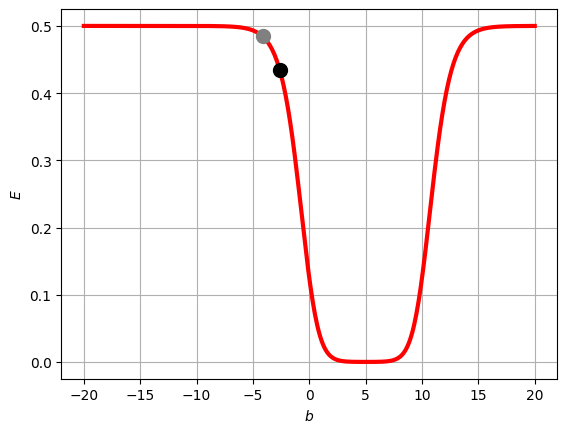

In [21]:
(fig, ax) = plt.subplots(1, 1)

sig = lambda x:1/(1 + np.exp(-x))
f = lambda x:0.5*((1 - sig(-10*0 + x))**2 + (0 - sig(-10*1 + x))**2)
xs = np.mgrid[-20:20.1:0.1]
ys = f(xs)

ax.set_xlabel('$b$')
ax.set_ylabel('$E$')
ax.plot(xs, ys, color='red', linestyle='-', linewidth=3)
ax.plot([-4.14], [f(-4.14)], color='grey', linestyle='', marker='o', markersize=10)
ax.plot([-2.62], [f(-2.62)], color='black', linestyle='', marker='o', markersize=10)
ax.grid()

Now we need to repeat this process for a set number of times, such as for 5 steps.

step b E
0 -4.14 0.48445
1 -2.62142 0.43452
2 3.26836 0.00067
3 3.39777 0.00052
4 3.49895 0.00043
5 3.58229 0.00037


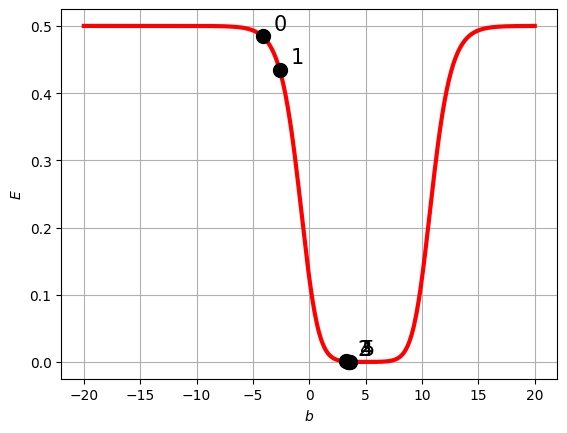

In [22]:
train_x = torch.tensor([0, 1], dtype=torch.float32, device=device)
train_y = torch.tensor([1, 0], dtype=torch.float32, device=device)

class Logistic(torch.nn.Module):

    def __init__(self, b):
        super().__init__()
        self.w = torch.nn.Parameter(torch.tensor(-10.0, dtype=torch.float32))
        self.b = torch.nn.Parameter(torch.tensor(b, dtype=torch.float32))

    def forward(self, x):
        return torch.sigmoid(x*self.w + self.b)

def get_error_and_grad(b):
    model = Logistic(b)
    model.to(device)
    error = torch.nn.functional.mse_loss(model(train_x), train_y)
    error.backward()
    grad = model.b.grad.tolist()
    model.b.grad.zero_()
    return (error.detach().tolist(), grad)

(fig, ax) = plt.subplots(1, 1)
ax.set_xlabel('$b$')
ax.set_ylabel('$E$')

bs = np.mgrid[-20:20.1:0.1]
es = [get_error_and_grad(b)[0] for b in bs]
ax.plot(bs, es, color='red', linestyle='-', linewidth=3)

b = -4.14
learning_rate = 100.0

print('step', 'b', 'E')
errors = []
for step in range(6):
    (e, g) = get_error_and_grad(b)
    errors.append(e)
    ax.plot(b, e, color='black', linestyle='', marker='o', markersize=10)
    ax.text(b + 1, e + 0.01, str(step), color='black', fontsize=15)
    print(step, round(b, 5), round(e, 5))
    b = b - learning_rate*g
ax.grid()

We can follow the trail of black points down the slope, getting closer and closer to the minimum error.
When the curve is steep, the point moves a lot, whilst when the curve is flat, the point moves slowly.
This is because we are moving proportionately with the gradient of the curve in order to try avoid jumping over the minimum point.
Keep in mind that this heuristic makes more sense when used in a high-dimensional space rather than in a 2D graph.

We can also plot a nice **step-error plot** showing how the error is changing with each step of optimisation.

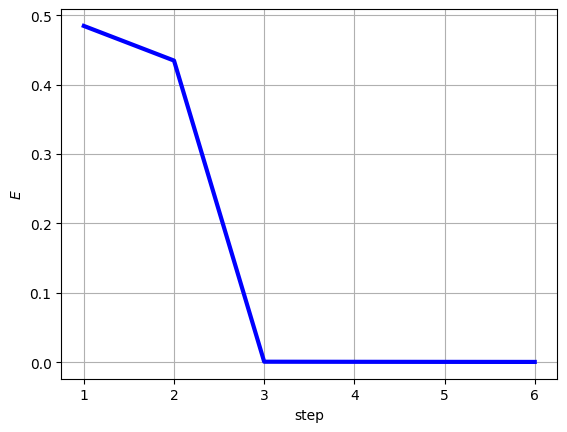

In [23]:
(fig, ax) = plt.subplots(1, 1)
ax.set_xlabel('step')
ax.set_ylabel('$E$')
ax.plot(range(1, 6 + 1), errors, color='blue', linestyle='-', linewidth=3)
ax.grid()

Step-error plots are much more accessible than parameter-error plots because it is always a 2D graph.

If we make the learning rate too large, gradient descent could overshoot the minimum and start jumping from one side of the valley to the other:

step b E
0 -4.14 0.48445
1 -1.55841 0.34124
2 18.61494 0.49982
3 18.58413 0.49981
4 18.55236 0.49981
5 18.51955 0.4998


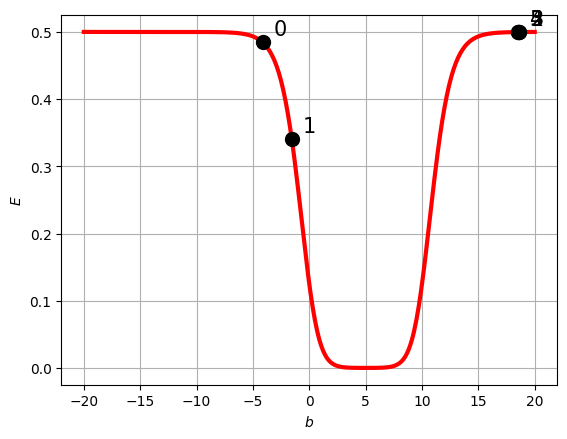

In [24]:
train_x = torch.tensor([0, 1], dtype=torch.float32, device=device)
train_y = torch.tensor([1, 0], dtype=torch.float32, device=device)

class Logistic(torch.nn.Module):

    def __init__(self, b):
        super().__init__()
        self.w = torch.nn.Parameter(torch.tensor(-10.0, dtype=torch.float32))
        self.b = torch.nn.Parameter(torch.tensor(b, dtype=torch.float32))

    def forward(self, x):
        return torch.sigmoid(x*self.w + self.b)

def get_error_and_grad(b):
    model = Logistic(b)
    model.to(device)
    error = torch.nn.functional.mse_loss(model(train_x), train_y)
    error.backward()
    grad = model.b.grad.tolist()
    model.b.grad.zero_()
    return (error.detach().cpu().tolist(), grad)

(fig, ax) = plt.subplots(1, 1)
ax.set_xlabel('$b$')
ax.set_ylabel('$E$')

bs = np.mgrid[-20:20.1:0.1]
es = [get_error_and_grad(b)[0] for b in bs]
ax.plot(bs, es, color='red', linestyle='-', linewidth=3)

b = -4.14
learning_rate = 170.0 # A learning rate that is too large.

print('step', 'b', 'E')
errors = []
for step in range(6):
    (e, g) = get_error_and_grad(b)
    errors.append(e)
    ax.plot(b, e, color='black', linestyle='', marker='o', markersize=10)
    ax.text(b + 1, e + 0.01, str(step), color='black', fontsize=15)
    print(step, round(b, 5), round(e, 5))
    b = b - learning_rate*g
ax.grid()

To mitigate for this, we typically avoid large learning rates.
On the other hand, small learning rates will require a lot of steps to make progress, which would be a waste of time.
A good learning rate needs to be chosen such that it balances the speed of optimisation with the **learning stability**.

You can check for whether this overshooting is happening by looking at the step-error plot:

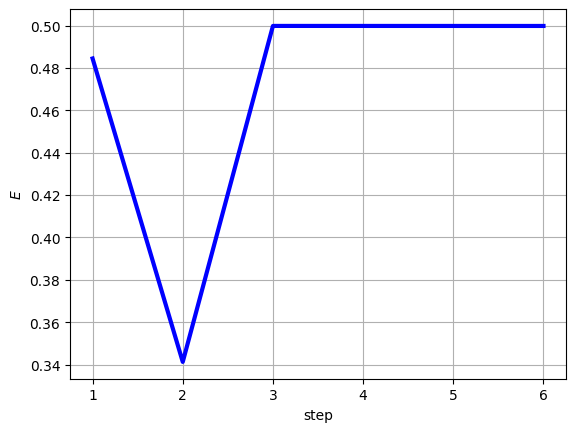

In [25]:
(fig, ax) = plt.subplots(1, 1)
ax.set_xlabel('step')
ax.set_ylabel('$E$')
ax.plot(range(1, 6 + 1), errors, color='blue', linestyle='-', linewidth=3)
ax.grid()

If the error starts jumping up and down without a general improvement then you've got stability issues and need to decrease your learning rate.

Now let's include $w$ in our parameter search.
This is what the entire error surface looks like when you include the $w$ parameter:

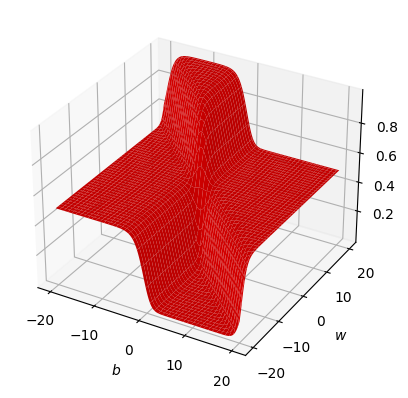

In [26]:
(fig, ax) = plt.subplots(1, 1, subplot_kw={'projection': '3d'})
ax.set_xlabel('$b$')
ax.set_ylabel('$w$')
ax.set_zlabel('$E$')

sig = lambda x:1/(1 + np.exp(-x))
f = lambda w,b:0.5*((1 - sig(w*0 + b))**2 + (0 - sig(w*1 + b))**2)
(ws, bs) = np.mgrid[-20:20.1:0.1, -20:20.1:0.1]
es = f(ws, bs)
ax.plot_surface(bs, ws, es, color='red', linewidth=0, antialiased=True)

Now we can see the whole picture.
We can see that the previous error surface was just a cross section of this 3D surface, specifically at $w=-10$.
We can see that there are four quadrants to the surface: a hill, two flat **plateaus**, and a valley.
Plateaus are a problem for gradient descent because the gradient would be very small and you'd be moving very slowly, resulting in very slow progress.

We can still use gradient descent when we have two parameters to optimise.
The only difference is that we'd be moving in two directions at once by following two gradients at once: one to update $w$ and one to update $b$.
Let's see what that will look like.

step w b E
0 1.3 -4.14 0.48597
1 1.01211 -2.90931 0.45815
2 -0.46712 0.26034 0.19531
3 -11.56031 -0.13316 0.14217
4 -11.56031 13.13895 0.34363
5 -23.31167 1.38759 0.01996
6 -23.31167 4.5818 5e-05


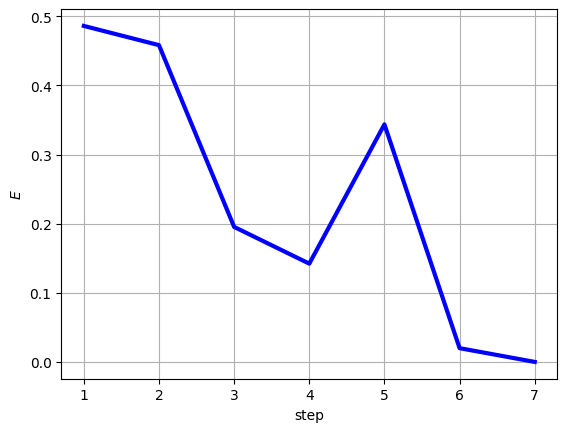

In [27]:
train_x = torch.tensor([0, 1], dtype=torch.float32, device=device)
train_y = torch.tensor([1, 0], dtype=torch.float32, device=device)

class Logistic(torch.nn.Module):

    def __init__(self, w, b):
        super().__init__()
        self.w = torch.nn.Parameter(torch.tensor(w, dtype=torch.float32))
        self.b = torch.nn.Parameter(torch.tensor(b, dtype=torch.float32))

    def forward(self, x):
        return torch.sigmoid(x*self.w + self.b)

def get_error_and_grad(w, b):
    model = Logistic(w, b)
    model.to(device)
    error = torch.nn.functional.mse_loss(model(train_x), train_y)
    error.backward()
    grad_w = model.w.grad.tolist()
    grad_b = model.b.grad.tolist()
    model.w.grad.zero_()
    model.b.grad.zero_()
    return (error.detach().cpu().tolist(), grad_w, grad_b)

b = -4.14
w = 1.3
learning_rate = 100.0

print('step', 'w', 'b', 'E')
errors = []
for step in range(7):
    (e, g_w, g_b) = get_error_and_grad(w, b)
    errors.append(e)
    print(step, round(w, 5), round(b, 5), round(e, 5))
    w = w - learning_rate*g_w
    b = b - learning_rate*g_b

(fig, ax) = plt.subplots(1, 1)
ax.set_xlabel('step')
ax.set_ylabel('$E$')
ax.plot(range(1, 7 + 1), errors, color='blue', linestyle='-', linewidth=3)
ax.grid()

By following the gradient we have found that $w=-23.31167$ and $b=4.5818$ result in a very small error ($E=0.00005$).

As already stated, with multiple parameters it's difficult to visualise how the parameter point was moving on the error surface during optimisation, so we usually just limit ourselves to the step-error plot in order to see how learning is progressing.
Note how, even though the error graph is not always moving downwards, it still tends downwards in general, so we don't need to reduce the learning rate.

## A better error function: cross entropy error

MSE can be used on many different models but, when the output is produced by a sigmoid or softmax, there is a better error function called **cross-entropy** (**XE**).

The problem with MSE is that, when used with sigmoid or softmax, it makes the error surface contain a lot of plateaus, and plateaus are bad for gradient descent.
Let's see the last error surface with MSE we saw again:

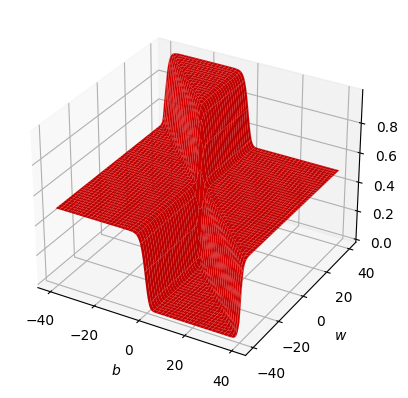

In [28]:
(fig, ax) = plt.subplots(1, 1, subplot_kw={'projection': '3d'})
ax.set_xlabel('$b$')
ax.set_ylabel('$w$')
ax.set_zlabel('$E$')

sig = lambda x:1/(1 + np.exp(-x))
f = lambda w,b:0.5*((1 - sig(w*0 + b))**2 + (0 - sig(w*1 + b))**2)
(ws, bs) = np.mgrid[-40:40.1:0.1, -40:40.1:0.1]
es = f(ws, bs)
ax.plot_surface(bs, ws, es, color='red', linewidth=0, antialiased=True)

XE avoids causing this problem (although it can still be caused by other things).
Whereas MSE can only give an error between 0 and 1 (for sigmoid outputs), XE can be between 0 and infinity.
Here is what the same error surface above would look like with XE:

C:\Users\User\AppData\Local\Temp\ipykernel_16268\3625924533.py:7: RuntimeWarning: divide by zero encountered in log
  f = lambda w,b:0.5*(-np.log(sig(w*0 + b)) + -np.log(1 - sig(w*1 + b)))
c:\Users\User\anaconda3\envs\deep_learning\lib\site-packages\mpl_toolkits\mplot3d\art3d.py:1187: RuntimeWarning: invalid value encountered in subtract
  v2[poly_i, :] = ps[i2, :] - ps[i3, :]
c:\Users\User\anaconda3\envs\deep_learning\lib\site-packages\mpl_toolkits\mplot3d\art3d.py:1186: RuntimeWarning: invalid value encountered in subtract
  v1[poly_i, :] = ps[i1, :] - ps[i2, :]


c:\Users\User\anaconda3\envs\deep_learning\lib\site-packages\mpl_toolkits\mplot3d\proj3d.py:180: RuntimeWarning: invalid value encountered in divide
  txs, tys, tzs = vecw[0]/w, vecw[1]/w, vecw[2]/w


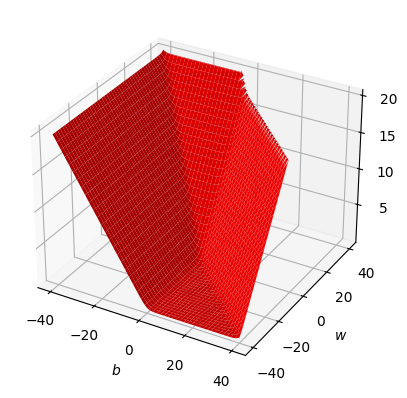

In [29]:
(fig, ax) = plt.subplots(1, 1, subplot_kw={'projection': '3d'})
ax.set_xlabel('$b$')
ax.set_ylabel('$w$')
ax.set_zlabel('$E$')

sig = lambda x:1/(1 + np.exp(-x))
f = lambda w,b:0.5*(-np.log(sig(w*0 + b)) + -np.log(1 - sig(w*1 + b)))
(ws, bs) = np.mgrid[-40:40.1:0.1, -40:40.1:0.1]
es = f(ws, bs)
ax.plot_surface(bs, ws, es, color='red', linewidth=0, antialiased=True)

Note how the minimum is still exactly where it was with MSE, but now everything else is a steep slide towards that minimum region, which makes gradient descent very efficient!

Instead of taking the mean of square differences, XE takes the mean of negative logs of the output.
The negative log function ($-\ln(x)$) is infinity at $x=0$ and 1 at $x=1$:

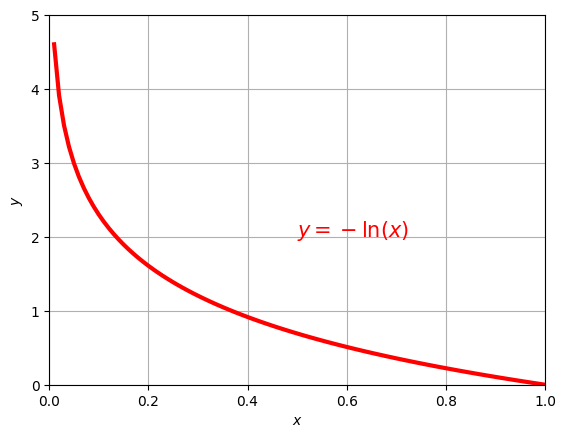

In [30]:
(fig, ax) = plt.subplots(1, 1)

xs = np.mgrid[0.01:1.01:0.01]
ys = -np.log(xs)

ax.set_xlim(0.0, 1.0)
ax.set_ylim(0.0, 5.0)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.plot(xs, ys, color='red', linestyle='-', linewidth=3)
ax.text(0.5, 2.0, '$y = -\ln(x)$', color='red', fontsize=15.0)
ax.grid()

Taken as an error value, this means that if the model outputs a 0 then you have an error of 0 and if the model outputs a 1 then you have infinite error.
This means that we'd be expecting the output to be 1, but what if we wanted the model to output a 0?
In that case we use $-ln(1-x)$ instead:

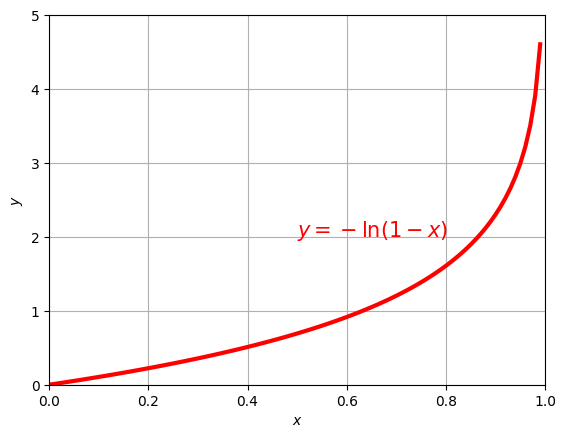

In [31]:
(fig, ax) = plt.subplots(1, 1)

xs = np.mgrid[0.0:1.0:0.01]
ys = -np.log(1-xs)

ax.set_xlim(0.0, 1.0)
ax.set_ylim(0.0, 5.0)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.plot(xs, ys, color='red', linestyle='-', linewidth=3)
ax.text(0.5, 2.0, '$y = -\ln(1-x)$', color='red', fontsize=15.0)
ax.grid()

It's the same thing but flipped around.

Given that the target output is going to be either 0 or 1, we can combine these two functions into one like this:

$$-\ln(x)t + -\ln(1-x)(1-t)$$

which is saying that when the target is 0 then only consider $-\ln(1-x)$ (the other term gets multiplied by zero) and when the target is 1 then only consider $-\ln(x)$ (the other term gets multiplied by zero).
This makes the complete error function as follows:

$$E = \frac{1}{n}\sum_i{\left(-\ln(y_i)t_i + -\ln(1-y_i)(1-t_i)\right)}$$

Using XE the way we did ends up causing numerical instability for very small outputs.
This is because you end up with huge numbers that aren't handled well.
To avoid this, the XE function in PyTorch requires you to not pass in the sigmoid values (`sig(w*x + b)`) directly but the linear bit we put inside the sigmoid (`w*x + b`) called the **logits**.
The PyTorch XE function uses a mathematically simplified version of `log(sig(logits))` that is more stable, so you just need to provide the logits.

This kind of cross entropy error is called **binary cross-entropy**, because it assumes that there are two possible target outputs.
This is why PyTorch calls it so:

In [32]:
y = torch.tensor([-10.0, 0.0, -10.0, 0.0], dtype=torch.float32, device=device) # Approximate logits that give [0.00005, 0.50000, 0.00005, 0.50000]
t = torch.tensor([  0.0, 0.0,   0.0, 1.0], dtype=torch.float32, device=device)
error = torch.nn.functional.binary_cross_entropy_with_logits(y, t)
print(error)

tensor(0.3466)


In the case of a softmax output, we'll need to use **categorical cross-entropy** instead, because it works on categorical values (a term from statistics).
In general, categorical cross-entropy finds the distance between two probability distributions, which is useful if you want your softmax to output specific probabilities.
For example, if I wanted all the probabilities in a softmax with 4 numbers to be equal, that is, $0.25$ each, then I would be measuring the distance of the softmax output from the vector `[0.25, 0.25, 0.25, 0.25]`.
In this case we'd use the following error function:

$$-\sum_j t_j\ln(y_j)$$

This is saying that you need to take the negative sum of the products of each target probability with the log of the corresponding softmax output.
For a whole training set we use this error function:

$$E = \frac{1}{n}\sum_i{-\sum_j t_{ij}\ln(y_{ij})}$$

where $y_{ij}$ means take the softmax output of the $i$<sup>th</sup> row in the training set and from that softmax vector extract the $j$<sup>th</sup> probability.

Again, using XE in this way results in instability, and again PyTorch expects you to provide logits to the softmax instead of the softmax directly.
Note that PyTorch just calls the function cross-entropy instead of categorical cross-entropy:

In [33]:
y = torch.tensor([
    [ 2.0, 1.0, -1.0, -1.0], # Approximate logits for softmax: 0.7, 0.3, 0.0, 0.0
    [-3.0, 3.0,  5.0, -1.0], # Approximate logits for softmax: 0.0, 0.1, 0.9, 0.0
    [-2.0, 7.0,  2.0,  1.0], # Approximate logits for softmax: 0.0, 1.0, 0.0, 0.0
], dtype=torch.float32, device=device)
t = torch.tensor([
    [1.0 , 0.0 , 0.0 , 0.0 ],
    [0.25, 0.25, 0.25, 0.25],
    [0.0 , 0.5 , 0.5 , 0.0 ],
], dtype=torch.float32, device=device)
error = torch.nn.functional.cross_entropy(y, t)
print(error)

tensor(2.3407)


But the most common use of a softmax is for when we want exactly one of the probabilities to be maximised whilst the other probabilities to come close to zero.
For example, if we're trying to classify the language of a text, and the softmax needs to give the probability of the text being in English, German, or Russian, we want the probability of the actual language of the text to be maximised and all the other language probabilities to be minimised.
When the target output vector is full of zeros and a single 1, the categorical cross-entropy formula becomes simplified as follows:

$$-\ln(y_t)$$

This is saying that out of all the probabilities in the output, take the **target probability**, which is the number in the softmax output that should be equal to 1, and take the negative log of that probability.
Another way to see this is that we're just maximising the target probability and letting softmax reduce the other probabilities (since they must sum to 1).
This makes the complete error function as follows:

$$E = \frac{1}{n}\sum_i{-\ln(y_{it_i})}$$

where $y_{it_i}$ means take the softmax output of the $i$<sup>th</sup> row in the training set and extract its target probability ($t_i$).

In this case, we can also use PyTorch's `cross_entropy` function, but we need to pass in single integers as targets instead of vectors of floats, where the integers are the indexes of the target probabilities.

In [34]:
y = torch.tensor([
    [ 2.0, 1.0, -1.0, -1.0], # Approximate logits for softmax: 0.7, 0.3, 0.0, 0.0
    [-3.0, 3.0,  5.0, -1.0], # Approximate logits for softmax: 0.0, 0.1, 0.9, 0.0
    [-2.0, 7.0,  2.0,  1.0], # Approximate logits for softmax: 0.0, 1.0, 0.0, 0.0
], dtype=torch.float32, device=device)
t = torch.tensor([
    0, # First probability should be 1.
    2, # Third probability should be 1.
    0, # First probability should be 1.
], dtype=torch.int64, device=device)
error = torch.nn.functional.cross_entropy(y, t)
print(error)

tensor(3.1741)


## A practical example with sigmoid

Let's try creating a binary logistic regression classifier that is trained to classify the sentiment of a text review using a reduced version of the [Large Movie Review Dataset](https://ai.stanford.edu/~amaas/data/sentiment/), which is a set of movie reviews taken from IMDB that are annotated with whether the review was positive or negative.
Let's start by seeing the data first.

In [35]:
train_df = pd.read_csv('../data_set/sentiment/train.csv')

train_x = train_df['text']
train_y = train_df['class']
categories = ['neg', 'pos'] # neg -> 0, pos -> 1
cat2idx = {cat: i for (i, cat) in enumerate(categories)}

train_y_idx = train_y.map(cat2idx.get).to_numpy()

print('Data set size')
print('train:', len(train_x))
print()
print('First train_x')
print(train_x[0])
print()
print('First train_y')
print(train_y[0])
print()
print('First train_y_idx')
print(train_y_idx[0])

Data set size
train: 10000

First train_x
i must admit , out of the eros movie collection , this has to be the one that i love the most as well as one other that i have also reviewed . the story is something that really keeps you watching . a lot of the eros films have

First train_y
pos

First train_y_idx
1


Now we need to convert these texts into numeric tensors, simplest way being converting them into **bag of words vectors** (**BOW**).
A bag of words vector is a way to represent texts into numeric vectors by simply indicating if a word is present in the text or not.
For example, if our vocabulary of possible words is `['cat', 'dog', 'bit', 'scratched']`, then the sentence "the dog bit the cat" will be represented as `[1, 1, 1, 0]` because 'cat', 'dog', and 'bit' were all used but 'scratched' wasn't.
We'll be considering only the 1000 most frequent words in the training set as our vocabulary in order to make the vectors smaller and the process faster.

We'll be using Scikit-Learn to convert our texts.

In [36]:
encoder = sklearn.feature_extraction.text.CountVectorizer(max_features=1000, binary=True, stop_words='english', lowercase=True, tokenizer=nltk.word_tokenize, dtype=np.float32)
encoder.fit(train_x)

train_x_bow = encoder.transform(train_x).toarray()

vocabulary = sorted(encoder.vocabulary_.keys(), key=encoder.vocabulary_.get)

print('First train_x_bow')
print(train_x_bow[0])
print()
print('Vocabulary')
print(vocabulary)

c:\Users\User\anaconda3\envs\deep_learning\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


First train_x_bow
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

Now we need to create a PyTorch module for our binary logistic regression classifier.
Remember that we need to initialise our parameters (the weights and biases) using random numbers to use gradient descent properly.
Rather than using `w` and `b`, we can make use of the `Linear` module which contains weights and biases and initialises the parameters randomly for us.
This results in neater and less cluttered code.

In [37]:
class Logistic(torch.nn.Module):

    def __init__(self, vocab_size, num_categories):
        super().__init__()
        self.linear = torch.nn.Linear(vocab_size, num_categories)
        
    def forward(self, x):
        return self.linear(x) # Return the logits only.

And now we can start optimising the parameters.
We're going to use a built-in gradient descent optimiser instead of making our own like we were doing.
In PyTorch, this is called `SGD` for **stochastic gradient descent**.
We'll see what the 'stochastic' bit is referring to in the next topic.

Another important change we'll do from the previous code examples is that we'll be passing the whole training set at once as an input to the model rather than execute the model for each training set item separately.
This is possible thanks to the fact that we're using a matrix multiplication in the forward function above.
Up to now we've only seen a matrix multiplication being used to multiply a vector input by a weight matrix.
If the input is a matrix instead of a vector, then you will have a separate output for each row in the input matrix.

Here we're matrix-multiplying a single row input to a weight matrix:

$\left(\begin{matrix}1 & 2\end{matrix}\right)\left(\begin{matrix}10 & 30 \\ 20 & 40\end{matrix}\right) = \left(\begin{matrix}70 & 100\end{matrix}\right)$

And here we're matrix-multiplying a matrix of row inputs to a weight matrix:

$\left(\begin{matrix}1 & 2 \\ 3 & 4 \\ 5 & 6\end{matrix}\right)\left(\begin{matrix}10 & 30 \\ 20 & 40\end{matrix}\right) = \left(\begin{matrix}70 & 100 \\ 150 & 220 \\ 230 & 340\end{matrix}\right)$

See how you end up with a separate row output for each row input?
If you're using a GPU, this results in much faster computation of outputs than if you had to compute each row separately.

step error
100 0.6605141758918762
200 0.6376780867576599
300 0.6207120418548584
400 0.6073709726333618
500 0.5964870452880859
600 0.5873653292655945
700 0.5795580148696899
800 0.5727614164352417
900 0.5667619705200195
1000 0.5614047050476074
1100 0.5565746426582336
1200 0.5521844029426575
1300 0.5481660962104797
1400 0.544466495513916
1500 0.5410428047180176
1600 0.5378603935241699
1700 0.5348908305168152
1800 0.5321102142333984
1900 0.5294986367225647
2000 0.527039110660553
2100 0.5247172117233276
2200 0.5225204229354858
2300 0.5204375982284546
2400 0.5184594392776489
2500 0.5165773034095764
2600 0.5147839784622192
2700 0.513072669506073
2800 0.5114374756813049
2900 0.50987309217453
3000 0.5083746314048767
3100 0.5069378614425659
3200 0.5055586695671082
3300 0.5042335391044617
3400 0.5029591917991638
3500 0.501732587814331
3600 0.5005510449409485
3700 0.49941185116767883
3800 0.4983128309249878
3900 0.4972516596317291
4000 0.49622654914855957
4100 0.4952353537082672
4200 0.49427661299

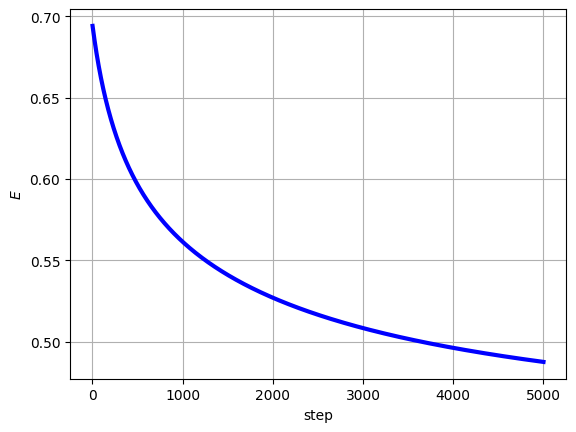

In [38]:
model = Logistic(len(vocabulary), 1) # Single output (between 0 and 1).
model.to(device)

# Create a gradient descent optimiser that optimises all parameters of the model with a learning rate of 2.0.
optimiser = torch.optim.SGD(model.parameters(), lr=0.1)

tensor_x = torch.tensor(train_x_bow, dtype=torch.float32, device=device)
tensor_t = torch.tensor(train_y_idx, dtype=torch.float32, device=device)

# Optimise the parameters for 1000 steps.
print('step', 'error')
train_errors = []
for step in range(1, 5000 + 1):
    optimiser.zero_grad() # Make all gradients zero.
    output = model(tensor_x)[:, 0] # Convert the single-column matrix into a vector.
    train_error = torch.nn.functional.binary_cross_entropy_with_logits(output, tensor_t)
    train_errors.append(train_error.detach().cpu().tolist())
    train_error.backward()
    optimiser.step() # Apply a gradient descent step.

    if step%100 == 0:
        print(step, train_errors[-1])

(fig, ax) = plt.subplots(1, 1)
ax.set_xlabel('step')
ax.set_ylabel('$E$')
ax.plot(range(1, len(train_errors) + 1), train_errors, color='blue', linestyle='-', linewidth=3)
ax.grid()

And finally, we can use the model to make a prediction:

In [39]:
text = 'i must admit , out of the eros movie collection , this has to be the one that i love the most as well as one other that i have also reviewed . the story is something that really keeps you watching . a lot of the eros films have'
bow = encoder.transform([text]).toarray()
tensor_x = torch.tensor(bow, dtype=torch.float32, device=device)
output_prob = torch.sigmoid(model(tensor_x))[0, 0]
print(output_prob)

tensor(0.8339, grad_fn=<SelectBackward0>)


## A practical example using softmax

Here is the same thing but this time using softmax.
Using softmax when you have a binary classification problem means having two outputs that add up to one.
Of course this is pointless as one probability will just be equal to 1 minus the other probability, but this example will be useful to see how to use softmax.

In [40]:
train_df = pd.read_csv('../data_set/sentiment/train.csv')

train_x = train_df['text']
train_y = train_df['class']
categories = sorted(train_y.unique().tolist()) # Collect all categories (assuming you have many) and sort them so that they are in a fixed order.
cat2idx = {cat: i for (i, cat) in enumerate(categories)}

train_y_idx = train_y.map(cat2idx.get).to_numpy()

In [41]:
encoder = sklearn.feature_extraction.text.CountVectorizer(max_features=1000, binary=True, stop_words='english', lowercase=True, tokenizer=nltk.word_tokenize, dtype=np.float32)
encoder.fit(train_x)

train_x_bow = encoder.transform(train_x).toarray()

vocabulary = sorted(encoder.vocabulary_.keys(), key=encoder.vocabulary_.get)

c:\Users\User\anaconda3\envs\deep_learning\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [42]:
class Logistic(torch.nn.Module):

    def __init__(self, vocab_size, num_categories):
        super().__init__()
        self.linear = torch.nn.Linear(vocab_size, num_categories)
        
    def forward(self, x):
        return self.linear(x)

step error
100 0.6373250484466553
200 0.6068922877311707
300 0.5868463516235352
400 0.5722367167472839
500 0.5608903169631958
600 0.5516882538795471
700 0.5439924597740173
800 0.5374100804328918
900 0.5316837430000305
1000 0.5266363024711609
1100 0.5221402645111084
1200 0.5181010961532593
1300 0.5144463777542114
1400 0.5111194252967834
1500 0.508074939250946
1600 0.5052763223648071
1700 0.5026931762695312
1800 0.5003001689910889
1900 0.4980763792991638
2000 0.49600356817245483
2100 0.49406614899635315
2200 0.4922509789466858
2300 0.49054643511772156
2400 0.48894232511520386
2500 0.48742982745170593
2600 0.4860011339187622
2700 0.48464927077293396
2800 0.48336800932884216
2900 0.48215195536613464
3000 0.48099613189697266
3100 0.47989609837532043
3200 0.47884780168533325
3300 0.477847695350647
3400 0.47689247131347656
3500 0.47597914934158325
3600 0.47510501742362976
3700 0.4742676615715027
3800 0.47346460819244385
3900 0.4726939797401428
4000 0.471953809261322
4100 0.4712422788143158
42

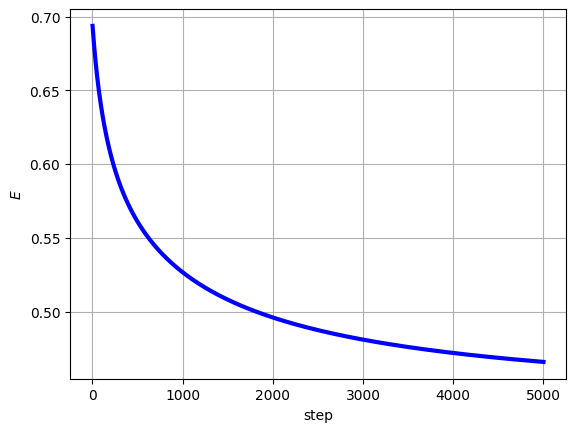

In [43]:
model = Logistic(len(vocabulary), 2) # Two outputs now.
model.to(device)

optimiser = torch.optim.SGD(model.parameters(), lr=0.1)

tensor_x = torch.tensor(train_x_bow, dtype=torch.float32, device=device)
tensor_t = torch.tensor(train_y_idx, dtype=torch.int64, device=device) # Data type of targets should be int64 instead of float32.

print('step', 'error')
train_errors = []
for step in range(1, 5000 + 1):
    optimiser.zero_grad()
    output = model(tensor_x) # Leave the two-column matrix as-is.
    train_error = torch.nn.functional.cross_entropy(output, tensor_t)
    train_errors.append(train_error.detach().cpu().tolist())
    train_error.backward()
    optimiser.step()

    if step%100 == 0:
        print(step, train_errors[-1])

(fig, ax) = plt.subplots(1, 1)
ax.set_xlabel('step')
ax.set_ylabel('$E$')
ax.plot(range(1, len(train_errors) + 1), train_errors, color='blue', linestyle='-', linewidth=3)
ax.grid()

In [44]:
text = 'i must admit , out of the eros movie collection , this has to be the one that i love the most as well as one other that i have also reviewed . the story is something that really keeps you watching . a lot of the eros films have'
bow = encoder.transform([text]).toarray()
tensor_x = torch.tensor(bow, dtype=torch.float32, device=device)
output_prob = torch.sigmoid(model(tensor_x))[0, :]
print(output_prob)
print(categories)

tensor([0.2750, 0.7193], grad_fn=<SliceBackward0>)
['neg', 'pos']
